<a href="https://colab.research.google.com/github/FatimaDahwi/SignEase-Sign-Language-learning-Platform/blob/main/SignEaseWordsModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
BASE_PATH = "/content/drive/MyDrive/asl_words/WLASL"
print(os.listdir(BASE_PATH))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['hello', 'thankyou', 'yes', 'mother', 'father', 'no', 'iloveyou', 'please']


In [ ]:
labels = sorted(os.listdir(BASE_PATH))
label_map = {label: idx for idx, label in enumerate(labels)}
print(label_map)
num_classes = len(labels)

{'father': 0, 'hello': 1, 'iloveyou': 2, 'mother': 3, 'no': 4, 'please': 5, 'thankyou': 6, 'yes': 7}


In [ ]:
!pip install tensorflow==2.18.0 mediapipe==0.10.21 opencv-python numpy tqdm


  Using cached mediapipe-0.10.21-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached sounddevice-0.5.3-py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
  Using cached jax-0.8.2-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.8.2-cp312-cp312-manylinux_2_27_x86_64.whl.metadata (1.3 kB)
  Using cached jax-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.8.1-cp312-cp312-manylin

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

mp_holistic = mp.solutions.holistic
TOTAL_FEATURES = 1662
MAX_FRAMES = 30

def extract_holistic_landmarks(video_path, max_frames=MAX_FRAMES):
    cap = cv2.VideoCapture(video_path)
    sequence = []

    with mp_holistic.Holistic(
        static_image_mode=False,
        model_complexity=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as holistic:

        while cap.isOpened() and len(sequence) < max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic.process(frame_rgb)

            pose = np.zeros(33*4)
            face = np.zeros(468*3)
            lh   = np.zeros(21*3)
            rh   = np.zeros(21*3)

            if results.pose_landmarks:
                pose = np.array([[l.x, l.y, l.z, l.visibility] for l in results.pose_landmarks.landmark]).flatten()
            if results.face_landmarks:
                face = np.array([[l.x, l.y, l.z] for l in results.face_landmarks.landmark]).flatten()
            if results.left_hand_landmarks:
                lh = np.array([[l.x, l.y, l.z] for l in results.left_hand_landmarks.landmark]).flatten()
            if results.right_hand_landmarks:
                rh = np.array([[l.x, l.y, l.z] for l in results.right_hand_landmarks.landmark]).flatten()

            frame_landmarks = np.concatenate([pose, face, lh, rh])
            # Padding
            if frame_landmarks.shape[0] < TOTAL_FEATURES:
                frame_landmarks = np.pad(frame_landmarks, (0, TOTAL_FEATURES - frame_landmarks.shape[0]))
            sequence.append(frame_landmarks)

    cap.release()

    # Pad frames
    while len(sequence) < max_frames:
        sequence.append(np.zeros(TOTAL_FEATURES))

    return np.array(sequence)

In [ ]:
import os
LANDMARKS_PATH = "/content/drive/MyDrive/asl_words/landmarks"
os.makedirs(LANDMARKS_PATH, exist_ok=True)

from tqdm import tqdm

for label in labels:
    label_path = os.path.join(BASE_PATH, label)
    save_label_path = os.path.join(LANDMARKS_PATH, label)
    os.makedirs(save_label_path, exist_ok=True)

    videos = [v for v in os.listdir(label_path) if v.endswith(".mp4")]
    print(f"Processing {label} ({len(videos)} videos)")

    for video in tqdm(videos):
        video_path = os.path.join(label_path, video)
        save_path = os.path.join(save_label_path, video.replace(".mp4", ".npy"))

        if os.path.exists(save_path):
            continue

        data = extract_holistic_landmarks(video_path)
        np.save(save_path, data)

Processing father (50 videos)


100%|██████████| 50/50 [03:05<00:00,  3.71s/it]


Processing hello (50 videos)


100%|██████████| 50/50 [02:52<00:00,  3.46s/it]


Processing iloveyou (24 videos)


100%|██████████| 24/24 [01:14<00:00,  3.09s/it]


Processing mother (51 videos)


100%|██████████| 51/51 [02:55<00:00,  3.44s/it]


Processing no (50 videos)


100%|██████████| 50/50 [02:42<00:00,  3.24s/it]


Processing please (50 videos)


100%|██████████| 50/50 [02:49<00:00,  3.39s/it]


Processing thankyou (50 videos)


100%|██████████| 50/50 [02:55<00:00,  3.51s/it]


Processing yes (50 videos)


100%|██████████| 50/50 [02:50<00:00,  3.40s/it]


In [ ]:
X, y = [], []

for label in labels:
    label_path = os.path.join(LANDMARKS_PATH, label)
    for file in os.listdir(label_path):
        if file.endswith(".npy"):
            X.append(np.load(os.path.join(label_path, file)))
            y.append(label_map[label])

X = np.array(X)
y = np.array(y)
print("Dataset shapes:", X.shape, y.shape)

Dataset shapes: (375, 30, 1662) (375,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (262, 30, 1662) Val: (56, 30, 1662) Test: (57, 30, 1662)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(MAX_FRAMES, TOTAL_FEATURES), name="lstm1"),
    Dropout(0.4, name="dropout1"),

    LSTM(64, return_sequences=False, name="lstm2"),
    Dropout(0.3, name="dropout2"),

    Dense(64, activation="relu", name="dense1"),
    Dense(num_classes, activation="softmax", name="output")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                    │ (None, 30, 128)        │       916,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 971,080 (3.70 MB)

 Trainable params: 971,080 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8
)


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.1344 - loss: 2.1158 - val_accuracy: 0.1429 - val_loss: 2.0359
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.1461 - loss: 2.0646 - val_accuracy: 0.3036 - val_loss: 1.9915
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.2466 - loss: 1.9818 - val_accuracy: 0.3750 - val_loss: 1.7724
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.3342 - loss: 1.7478 - val_accuracy: 0.5357 - val_loss: 1.4984
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.3672 - loss: 1.5742 - val_accuracy: 0.4643 - val_loss: 1.3173
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5035 - loss: 1.3883 - val_accuracy: 0.3571 - val_loss: 1.3349
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4623 - loss: 1.4173 - val_accuracy: 0.3214 - val_loss: 1.4754
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.4205 - loss: 1.4014 - val_accuracy: 0.5

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.6151 - loss: 0.9233
Test accuracy: 0.5789473652839661


In [ ]:
model.save("/content/drive/MyDrive/asl_words/model_asl_new.keras")
print("✅ Model saved in modern .keras format")


✅ Model saved in modern .keras format


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │     1,833,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,008,648 (7.66 MB)

 Trainable params: 2,007,880 (7.66 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 587ms/step - accuracy: 0.1822 - loss: 2.5541 - val_accuracy: 0.2143 - val_loss: 2.0585 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - accuracy: 0.2876 - loss: 2.1071 - val_accuracy: 0.1250 - val_loss: 2.0214 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step - accuracy: 0.3738 - loss: 1.7686 - val_accuracy: 0.1250 - val_loss: 2.0042 - learning_rate: 0.0010
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 450ms/step - accuracy: 0.3987 - loss: 1.6341 - val_accuracy: 0.2857 - val_loss: 1.9215 - learning_rate: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 461ms/step - accuracy: 0.4273 - loss: 1.4787 - val_accuracy: 0.1964 - val_loss: 1.8572 - learning_rate: 0.0010
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step - accuracy: 0.5231 - loss: 1.2439 - val_accuracy: 0.1607 - val_loss: 1.8850 - learning_rate: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 553ms/step - accuracy: 0.5705 - loss: 1.2563 

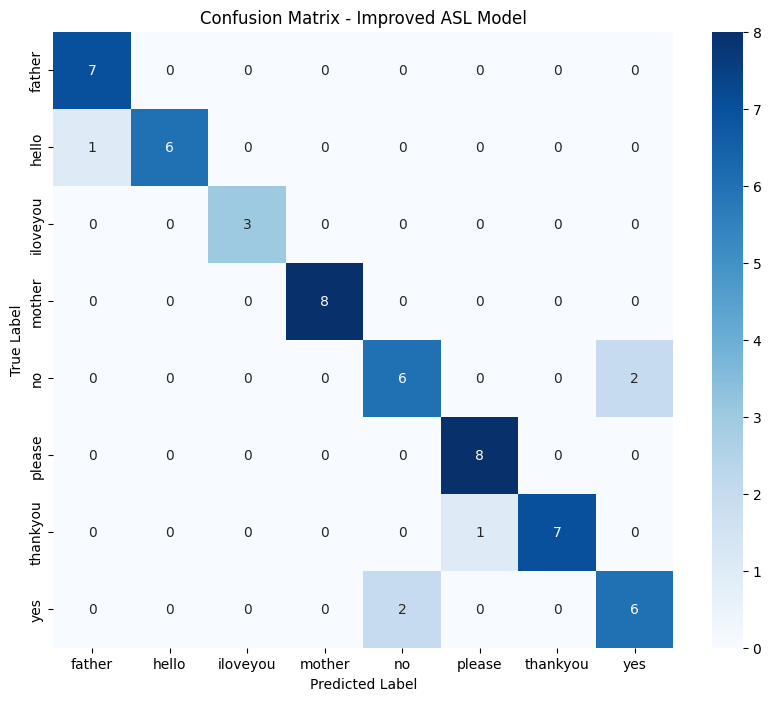

✅ Improved model saved!


In [ ]:

# Improved Training for ASL Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

MAX_FRAMES = 50


def pad_or_crop_sequence(X, max_frames=MAX_FRAMES):
    X_new = []
    for seq in X:
        if seq.shape[0] > max_frames:
            X_new.append(seq[:max_frames])
        elif seq.shape[0] < max_frames:
            pad = np.zeros((max_frames - seq.shape[0], seq.shape[1]))
            X_new.append(np.vstack([seq, pad]))
        else:
            X_new.append(seq)
    return np.array(X_new)

X_train_p = pad_or_crop_sequence(X_train)
X_val_p   = pad_or_crop_sequence(X_val)
X_test_p  = pad_or_crop_sequence(X_test)

# ======= تعريف الموديل =======
num_classes = len(labels)

improved_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(MAX_FRAMES, 1662)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(num_classes, activation="softmax")
])

improved_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

improved_model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Training
history = improved_model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, reduce_lr]
)

# Evaluation
test_loss, test_acc = improved_model.evaluate(X_test_p, y_test)
print("✅ Improved Test Accuracy:", test_acc)

#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = improved_model.predict(X_test_p)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Improved ASL Model")
plt.show()

# Save Model
improved_model.save("/content/drive/MyDrive/asl_words/model_asl_improved.keras")
print("✅ Improved model saved!")


Class distribution: {'hello': 50, 'thankyou': 50, 'yes': 50, 'mother': 51, 'father': 50, 'no': 50, 'iloveyou': 24, 'please': 50}


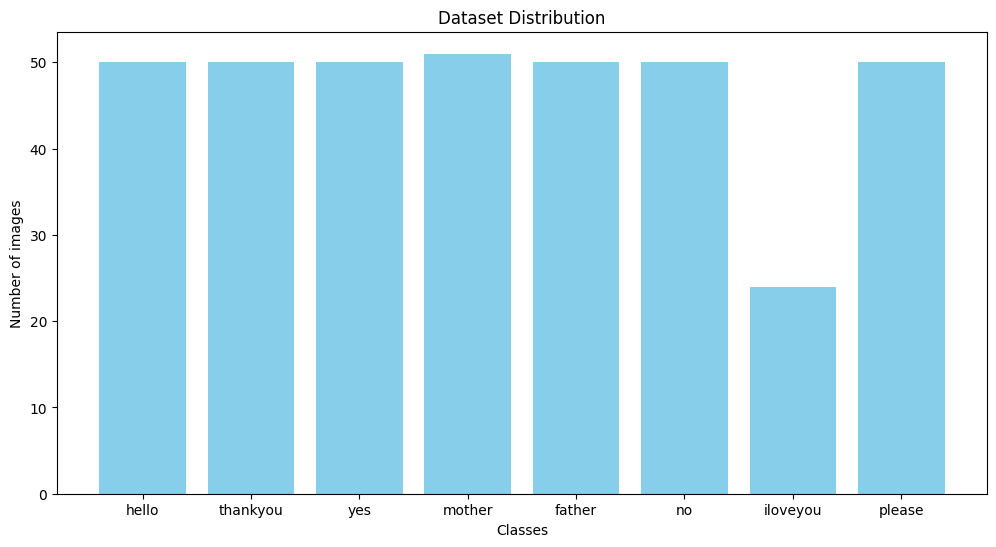

In [ ]:
import os
import matplotlib.pyplot as plt

dataset_path = "/content/drive/MyDrive/asl_words/WLASL"  # change to your folder path

# Count images per class
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

# Print counts
print("Class distribution:", class_counts)

# Plot distribution
plt.figure(figsize=(12,6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Dataset Distribution")
plt.show()


In [ ]:
import re
import matplotlib.pyplot as plt

log_file = "/content/drive/MyDrive/ASL_Project/wasl_training_log.txt"

# Lists to store metrics
train_acc, val_acc = [], []
train_loss, val_loss = [], []

with open(log_file, "r") as f:
    for line in f:
        # Extract training accuracy
        m_acc = re.search(r"accuracy: ([0-9.]+)", line)
        if m_acc:
            train_acc.append(float(m_acc.group(1)))

        # Extract training loss
        m_loss = re.search(r"loss: ([0-9.]+)", line)
        if m_loss:
            train_loss.append(float(m_loss.group(1)))

        # Extract validation accuracy
        m_val_acc = re.search(r"val_accuracy: ([0-9.]+)", line)
        if m_val_acc:
            val_acc.append(float(m_val_acc.group(1)))

        # Extract validation loss
        m_val_loss = re.search(r"val_loss: ([0-9.]+)", line)
        if m_val_loss:
            val_loss.append(float(m_val_loss.group(1)))

# Make sure all lists are the same length
min_len = min(len(train_acc), len(val_acc), len(train_loss), len(val_loss))
train_acc, val_acc = train_acc[:min_len], val_acc[:min_len]
train_loss, val_loss = train_loss[:min_len], val_loss[:min_len]

epochs = range(1, min_len+1)


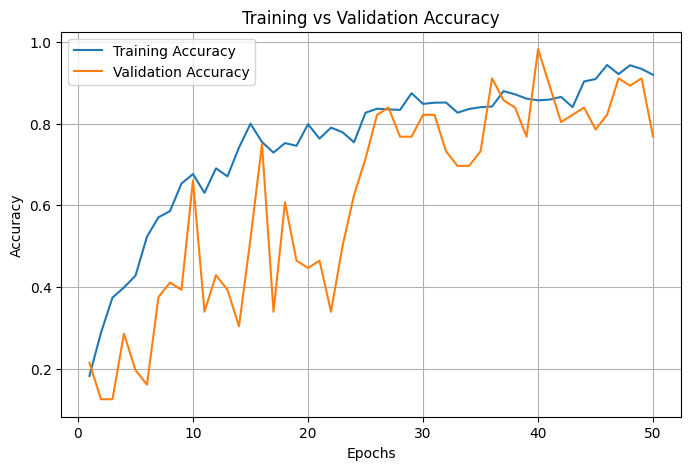

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


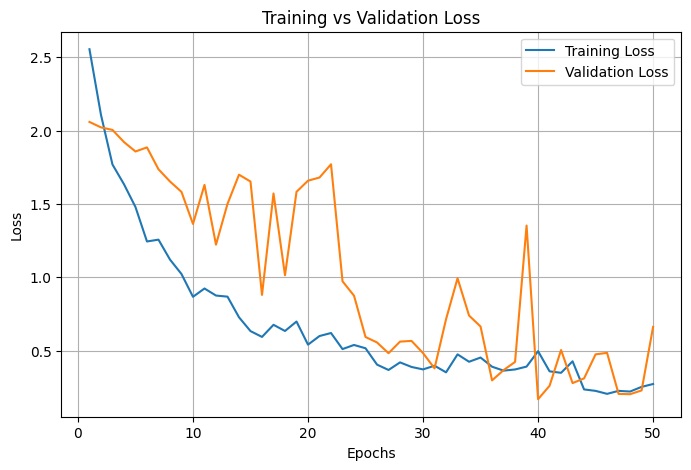

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import re
import matplotlib.pyplot as plt

log_file = "/content/drive/MyDrive/ASL_Project/wasl_training_log.txt"

train_acc, val_acc = [], []
train_loss, val_loss = [], []

with open(log_file, "r") as f:
    for line in f:
        # Match final epoch summary line only
        if " - accuracy:" in line and "val_accuracy" in line:
            acc = re.search(r"accuracy: ([0-9.]+)", line)
            loss = re.search(r"loss: ([0-9.]+)", line)
            v_acc = re.search(r"val_accuracy: ([0-9.]+)", line)
            v_loss = re.search(r"val_loss: ([0-9.]+)", line)

            if acc and loss and v_acc and v_loss:
                train_acc.append(float(acc.group(1)))
                train_loss.append(float(loss.group(1)))
                val_acc.append(float(v_acc.group(1)))
                val_loss.append(float(v_loss.group(1)))

epochs = range(1, len(train_acc) + 1)

print(f"Parsed {len(train_acc)} epochs successfully.")


Parsed 50 epochs successfully.


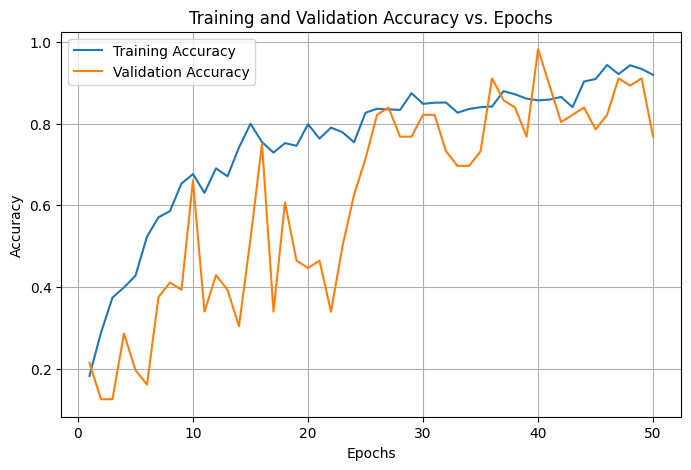

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


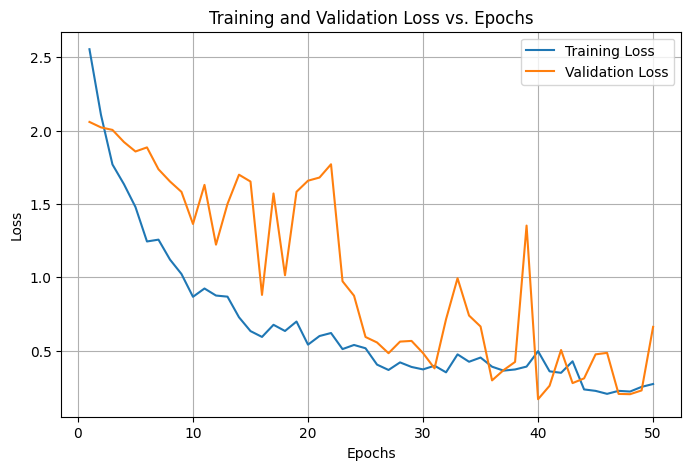

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()
